In [ ]:

# Analysis Plan:
# 1. Load all input data files (multi_grafting_sites.csv, cdr_library_summary.csv, 
#    allosteric_cdr_library.csv, known_niv_binders_full.fasta)
# 2. Filter CDR libraries to retain only CDRs with length < 10 amino acids
# 3. Parse novelty filter database from FASTA and CSV files
# 4. For each scaffold (1FNA, 1TEN, 2QMT):
#    a. Filter grafting site clusters for that scaffold
#    b. For each cluster, generate multi-graft designs by:
#       - Identifying the epitope type (competitive or allosteric) based on cluster residues
#       - Selecting appropriate CDR library
#       - Creating combinations of CDRs (one per position in cluster)
#       - Constructing the multi-graft sequence
#       - Calculating normalized physics-based interaction score
#       - Applying 10-AA sliding window novelty filter
# 5. Rank all designs by normalized interaction score
# 6. Output top 50 novel designs to novel_multi_cdr_designs.csv
# 7. Generate summary statistics and final visualization

import pandas as pd
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings('ignore')

print("Analysis plan defined. Loading input data files...")


Analysis plan defined. Loading input data files...


In [ ]:

# Load multi-grafting sites data
multi_graft_df = pd.read_csv('multi_grafting_sites.csv')
print(f"Loaded multi_grafting_sites.csv: {multi_graft_df.shape}")
print(multi_graft_df.head())
print("\nColumns:", multi_graft_df.columns.tolist())


Loaded multi_grafting_sites.csv: (87, 14)
  Scaffold  Cluster_ID  Cluster_Size                           Residues  \
0     1FNA           1             5   ARG6, LEU19, GLU47, THR58, PRO87   
1     1FNA           2             5   ASP7, LEU19, GLU47, THR58, PRO87   
2     1FNA           3             5  VAL11, ASP23, GLU47, THR58, PRO87   
3     1FNA           4             5  ALA12, ASP23, GLU47, THR58, ILE90   
4     1FNA           5             5  ALA13, ASP23, GLU47, THR58, ILE90   

                                     Residue_Numbers  Centroid_X  Centroid_Y  \
0  [np.int64(6), np.int64(19), np.int64(47), np.i...     -2.3504     23.2450   
1  [np.int64(7), np.int64(19), np.int64(47), np.i...     -1.6606     22.9812   
2  [np.int64(11), np.int64(23), np.int64(47), np....     -1.8532     22.6954   
3  [np.int64(12), np.int64(23), np.int64(47), np....      0.4280     21.7176   
4  [np.int64(13), np.int64(23), np.int64(47), np....      0.6718     21.7376   

   Centroid_Z  Min_Spatial

In [ ]:

# Load CDR libraries
competitive_cdr_df = pd.read_csv('cdr_library_summary.csv')
print(f"Loaded cdr_library_summary.csv: {competitive_cdr_df.shape}")
print(competitive_cdr_df.head())

allosteric_cdr_df = pd.read_csv('allosteric_cdr_library.csv')
print(f"\nLoaded allosteric_cdr_library.csv: {allosteric_cdr_df.shape}")
print(allosteric_cdr_df.head())


Loaded cdr_library_summary.csv: (12, 8)
  Antibody CDR Chain_Type           Sequence  Length           PDB_IDs  \
0      1E5  H1      Heavy         GGSISDTYRW      10  8K0C, 8K0D, 8XC4   
1      1E5  H2      Heavy           IYGSATST       8  8K0C, 8K0D, 8XC4   
2      1E5  H3      Heavy  ARDYQYYYSGSYPTPHN      17  8K0C, 8K0D, 8XC4   
3      1E5  L1      Light       RASQGIIDYLSW      12  8K0C, 8K0D, 8XC4   
4      1E5  L2      Light           TASNLESG       8  8K0C, 8K0D, 8XC4   

    Chains  Num_Instances  
0  C, E, G              6  
1  C, E, G              6  
2  C, E, G              6  
3  D, F, H              6  
4  D, F, H              6  

Loaded allosteric_cdr_library.csv: (21, 7)
          CDR_ID Antibody   PDB Chain CDR_Type     Sequence  Length
0  7TXZ_E_CDR-H1   nAH1.3  7TXZ     E   CDR-H1     GFSFSYYW       8
1  7TXZ_E_CDR-H2   nAH1.3  7TXZ     E   CDR-H2     IRLKSNNY       8
2  7TXZ_E_CDR-H3   nAH1.3  7TXZ     E   CDR-H3  IYYCTRVITTV      11
3  7TXZ_H_CDR-H1   nAH1.3  7TXZ

In [ ]:

# Load known binder sequences from FASTA for novelty checking
def parse_fasta(filename):
    """Parse FASTA file and return list of sequences"""
    sequences = []
    with open(filename, 'r') as f:
        current_seq = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(''.join(current_seq))
                    current_seq = []
            else:
                current_seq.append(line)
        if current_seq:
            sequences.append(''.join(current_seq))
    return sequences

known_sequences = parse_fasta('known_niv_binders_full.fasta')
print(f"Loaded {len(known_sequences)} known binder sequences from FASTA")
for i, seq in enumerate(known_sequences):
    print(f"  Sequence {i+1}: {len(seq)} AA")


Loaded 6 known binder sequences from FASTA
  Sequence 1: 242 AA
  Sequence 2: 214 AA
  Sequence 3: 233 AA
  Sequence 4: 219 AA
  Sequence 5: 235 AA
  Sequence 6: 214 AA


In [ ]:

# Filter CDR libraries to retain only CDRs with length < 10 amino acids
# Competitive CDRs
comp_short = competitive_cdr_df[competitive_cdr_df['Length'] < 10].copy()
print(f"Competitive CDRs: {len(competitive_cdr_df)} total, {len(comp_short)} with length < 10 AA")
print(comp_short[['Antibody', 'CDR', 'Sequence', 'Length']])

# Allosteric CDRs
allo_short = allosteric_cdr_df[allosteric_cdr_df['Length'] < 10].copy()
print(f"\nAllosteric CDRs: {len(allosteric_cdr_df)} total, {len(allo_short)} with length < 10 AA")
print(allo_short[['Antibody', 'CDR_Type', 'Sequence', 'Length']].drop_duplicates())


Competitive CDRs: 12 total, 7 with length < 10 AA
   Antibody CDR   Sequence  Length
1       1E5  H2   IYGSATST       8
4       1E5  L2   TASNLESG       8
5       1E5  L3  LQGYTTPYT       9
7      14F8  H2   WTGGVTNY       8
8      14F8  H3      VREGD       5
10     14F8  L2   QLLIYKVS       8
11     14F8  L3  FQASHVPYT       9

Allosteric CDRs: 21 total, 12 with length < 10 AA
   Antibody CDR_Type  Sequence  Length
0    nAH1.3   CDR-H1  GFSFSYYW       8
1    nAH1.3   CDR-H2  IRLKSNNY       8
7    nAH1.3   CDR-L2  LIYSASNQ       8
10   nAH1.3   CDR-L2  LLIYSASN       8
12     41-6   CDR-H1  FSFSYYWM       8
13     41-6   CDR-H2  NYGTHYRF       8
14     41-6   CDR-H1  YWMNWVRQ       8
15     41-6   CDR-H2  HYAEVKRF       8
17     41-6   CDR-L2  YSASNQGS       8
20     41-6   CDR-L2  PARFSGSG       8


In [ ]:

# Add CDR sequences from CSV files to the novelty filter database
# Extract all sequences from competitive and allosteric CDR libraries
cdr_sequences = list(competitive_cdr_df['Sequence'].values) + list(allosteric_cdr_df['Sequence'].values)
print(f"Added {len(cdr_sequences)} CDR sequences to novelty filter database")

# Combine all sequences for novelty checking
all_known_sequences = known_sequences + cdr_sequences
print(f"Total sequences in novelty filter database: {len(all_known_sequences)}")


Added 33 CDR sequences to novelty filter database
Total sequences in novelty filter database: 39


In [ ]:

# Load scaffold sequences from PDB files to construct multi-graft designs
def parse_pdb_sequence(pdb_file, chain='A'):
    """Extract amino acid sequence from PDB file for specified chain"""
    # Dictionary for 3-letter to 1-letter amino acid code conversion
    aa_code = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
        'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
        'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
        'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    
    residues = []
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':  # Alpha carbon only
                chain_id = line[21]
                if chain_id == chain:
                    res_name = line[17:20].strip()
                    res_num = int(line[22:26].strip())
                    if res_name in aa_code:
                        residues.append((res_num, aa_code[res_name]))
    
    # Sort by residue number and extract sequence
    residues.sort(key=lambda x: x[0])
    sequence = ''.join([r[1] for r in residues])
    return sequence

# Note: We don't have scaffold PDB files (1FNA.pdb, 1TEN.pdb, 2QMT.pdb) in the directory
# We need to load them or define scaffold sequences
# Let me check what PDB files we have
import os
pdb_files = [f for f in os.listdir('.') if f.endswith('.pdb')]
print(f"Available PDB files: {pdb_files}")


Available PDB files: ['2VSM.pdb']


In [ ]:

# We need to download the scaffold PDB files (1FNA, 1TEN, 2QMT)
# Let's download them directly from RCSB PDB

import urllib.request

scaffold_pdbs = ['1FNA', '1TEN', '2QMT']
scaffold_sequences = {}

for pdb_id in scaffold_pdbs:
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    filename = f'{pdb_id}.pdb'
    
    try:
        print(f"Downloading {pdb_id}.pdb...")
        urllib.request.urlretrieve(url, filename)
        
        # Parse the sequence from the downloaded PDB
        seq = parse_pdb_sequence(filename, chain='A')
        scaffold_sequences[pdb_id] = seq
        print(f"  {pdb_id}: {len(seq)} residues")
    except Exception as e:
        print(f"  Error downloading {pdb_id}: {e}")

print(f"\nSuccessfully loaded {len(scaffold_sequences)} scaffold sequences")


  1FNA: 91 residues
  1TEN: 89 residues
  2QMT: 56 residues

Successfully loaded 3 scaffold sequences


In [ ]:

# Display scaffold sequences
for pdb_id, seq in scaffold_sequences.items():
    print(f"{pdb_id}: {seq}")


1FNA: RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVPGSKSTATISGLKPGVDYTITVYAVTGRGDSPASSKPISINYRTEI
1TEN: LDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDLTEDENQYSIGNLKPDTEYEVSLISRRGDMSSNPAKETFTT
2QMT: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE


In [ ]:

# Implement the 10-AA sliding window novelty filter
def passes_novelty_filter(sequence, known_sequences, window_size=10):
    """
    Check if a sequence passes the novelty filter using a sliding window approach.
    Returns True if no 10-AA window has 100% identity with any known sequence.
    """
    if len(sequence) < window_size:
        # For sequences shorter than window, check exact match
        return sequence not in known_sequences
    
    # Generate all windows from the test sequence
    for i in range(len(sequence) - window_size + 1):
        window = sequence[i:i+window_size]
        
        # Check if this window appears in any known sequence
        for known_seq in known_sequences:
            if window in known_seq:
                return False
    
    return True

# Test the novelty filter
test_seq = "ACDEFGHIJK"
print(f"Testing novelty filter with sequence: {test_seq}")
result = passes_novelty_filter(test_seq, all_known_sequences)
print(f"Passes novelty filter: {result}")


Testing novelty filter with sequence: ACDEFGHIJK
Passes novelty filter: True


In [ ]:

# Define competitive and allosteric epitope residues
# Based on the dataset description
competitive_epitope_residues = [
    239, 240, 241, 242, 305, 401, 402, 403, 490, 491, 492, 501, 502, 504, 505, 506, 531, 532, 533, 557
]

# For allosteric, we'll need to load from PDB files 7TXZ and 7TY0
# For now, we'll use a placeholder approach based on the description
# The allosteric epitope was defined from interface residues in 7TXZ and 7TY0

print("Competitive epitope residues:", competitive_epitope_residues)
print(f"Total competitive epitope residues: {len(competitive_epitope_residues)}")


Competitive epitope residues: [239, 240, 241, 242, 305, 401, 402, 403, 490, 491, 492, 501, 502, 504, 505, 506, 531, 532, 533, 557]
Total competitive epitope residues: 20


In [ ]:

# Since we don't have the target (NiV-G) structure or epitope mapping information,
# we'll need to make a reasonable assumption for determining epitope types.
# The multi_grafting_sites.csv defines clusters on the SCAFFOLDS (1FNA, 1TEN, 2QMT),
# not on the NiV-G target protein.

# For this analysis, we'll use a simpler approach:
# - Assign epitope type based on cluster properties or use both CDR libraries
# - Since we're grafting onto scaffolds, we can't directly map to NiV-G epitopes
# - We'll create designs using BOTH competitive and allosteric CDRs
# - Let the scoring function determine which designs are better

print("Note: The grafting sites are on scaffold proteins, not on NiV-G.")
print("We'll generate designs using both competitive and allosteric CDR libraries.")
print("The physics-based scoring will help identify the best combinations.")


Note: The grafting sites are on scaffold proteins, not on NiV-G.
We'll generate designs using both competitive and allosteric CDR libraries.
The physics-based scoring will help identify the best combinations.


In [ ]:

# Implement physics-based interaction scoring function
# This is a simplified version that calculates pairwise interaction potentials
# Based on amino acid properties

def calculate_physics_score(sequence):
    """
    Calculate a physics-based interaction score for a sequence.
    This is a simplified scoring function based on pairwise residue interactions.
    Higher (less negative) scores indicate better predicted interactions.
    """
    # Simplified interaction matrix based on amino acid properties
    # Hydrophobic residues (A, V, I, L, M, F, W, P): favorable interactions
    # Charged residues (K, R, D, E): electrostatic interactions
    # Polar residues (S, T, N, Q, H, Y, C): moderate interactions
    # Glycine (G): flexible, neutral
    
    hydrophobic = set('AVILMFWP')
    positive = set('KR')
    negative = set('DE')
    polar = set('STNQHYC')
    aromatic = set('FWY')
    
    score = 0.0
    
    # Pairwise interactions within the sequence
    for i in range(len(sequence)):
        for j in range(i+1, len(sequence)):
            aa1, aa2 = sequence[i], sequence[j]
            
            # Distance-dependent (simple approximation: closer in sequence = stronger interaction)
            distance_factor = 1.0 / (abs(j - i) ** 0.5)
            
            # Hydrophobic-hydrophobic interactions (favorable)
            if aa1 in hydrophobic and aa2 in hydrophobic:
                score += 2.0 * distance_factor
            
            # Aromatic-aromatic interactions (pi-stacking)
            if aa1 in aromatic and aa2 in aromatic:
                score += 3.0 * distance_factor
            
            # Salt bridge (favorable)
            if (aa1 in positive and aa2 in negative) or (aa1 in negative and aa2 in positive):
                score += 4.0 * distance_factor
            
            # Polar-polar interactions
            if aa1 in polar and aa2 in polar:
                score += 1.0 * distance_factor
            
            # Charge-charge repulsion (unfavorable)
            if (aa1 in positive and aa2 in positive) or (aa1 in negative and aa2 in negative):
                score -= 2.0 * distance_factor
    
    return score

# Test the scoring function
test_seq = "AVILKDEFWY"
test_score = calculate_physics_score(test_seq)
print(f"Test sequence: {test_seq}")
print(f"Physics score: {test_score:.2f}")


Test sequence: AVILKDEFWY
Physics score: 31.57


In [ ]:

# Now let's generate multi-CDR graft designs
# For each scaffold and each cluster, we'll:
# 1. Parse the residue positions from the cluster
# 2. Create combinations of short CDRs (one per position)
# 3. Construct the grafted sequence by replacing scaffold residues with CDRs
# 4. Score the design using physics-based scoring (normalized by total CDR length)
# 5. Apply novelty filter

# First, let's understand the structure of multi_grafting_sites.csv better
print("Examining multi_grafting_sites data structure:")
print(f"Unique scaffolds: {multi_graft_df['Scaffold'].unique()}")
print(f"Cluster size distribution:")
print(multi_graft_df['Cluster_Size'].value_counts().sort_index())
print("\nExample residue data:")
print(multi_graft_df[['Scaffold', 'Cluster_ID', 'Residues', 'Residue_Numbers']].head(3))


Examining multi_grafting_sites data structure:
Unique scaffolds: ['1FNA' '1TEN' '2QMT']
Cluster size distribution:
Cluster_Size
3    16
4    43
5    28
Name: count, dtype: int64

Example residue data:
  Scaffold  Cluster_ID                           Residues  \
0     1FNA           1   ARG6, LEU19, GLU47, THR58, PRO87   
1     1FNA           2   ASP7, LEU19, GLU47, THR58, PRO87   
2     1FNA           3  VAL11, ASP23, GLU47, THR58, PRO87   

                                     Residue_Numbers  
0  [np.int64(6), np.int64(19), np.int64(47), np.i...  
1  [np.int64(7), np.int64(19), np.int64(47), np.i...  
2  [np.int64(11), np.int64(23), np.int64(47), np....  


In [ ]:

# The parse function is extracting too many numbers. Let me fix it
# The data appears to be numpy int64 objects in a list

def parse_residue_numbers(res_num_str):
    """Parse residue numbers from string representation"""
    import re
    # Extract only actual residue numbers (2-3 digit numbers)
    # Skip the '64' from 'np.int64'
    numbers = re.findall(r'np\.int64\((\d+)\)', str(res_num_str))
    if numbers:
        return [int(n) for n in numbers]
    else:
        # Fallback: just extract all numbers >= 2 digits that aren't part of 'int64'
        all_nums = re.findall(r'\b(\d{2,3})\b', str(res_num_str))
        # Filter out '64' which is from int64
        return [int(n) for n in all_nums if n != '64']

# Test parsing on the first few rows
test_rows = multi_graft_df.head(5)
for idx, row in test_rows.iterrows():
    res_nums = parse_residue_numbers(str(row['Residue_Numbers']))
    print(f"Cluster {row['Cluster_ID']} ({row['Scaffold']}): {res_nums} (size: {len(res_nums)})")


Cluster 1 (1FNA): [6, 19, 47, 58, 87] (size: 5)
Cluster 2 (1FNA): [7, 19, 47, 58, 87] (size: 5)
Cluster 3 (1FNA): [11, 23, 47, 58, 87] (size: 5)
Cluster 4 (1FNA): [12, 23, 47, 58, 90] (size: 5)
Cluster 5 (1FNA): [13, 23, 47, 58, 90] (size: 5)


In [ ]:

# Now let's create a function to construct multi-graft designs
# We'll graft CDRs at specified positions in the scaffold sequence
# IMPORTANT: The residue positions are 1-based from PDB, but the scaffold sequences
# might not start at position 1. We need to check the actual residue numbering.

def construct_multigraft_sequence(scaffold_seq, residue_positions, cdr_sequences):
    """
    Construct a multi-graft design by replacing scaffold residues with CDRs.
    
    Args:
        scaffold_seq: Original scaffold sequence
        residue_positions: List of 1-based residue positions to graft at
        cdr_sequences: List of CDR sequences to graft (same length as residue_positions)
    
    Returns:
        Modified sequence with CDRs grafted, or None if positions are invalid
    """
    # Convert to 0-based indexing
    positions_0based = [pos - 1 for pos in residue_positions]
    
    # Check if all positions are valid
    max_pos = max(positions_0based)
    if max_pos >= len(scaffold_seq):
        # Position out of range - this means PDB numbering doesn't match sequence indexing
        return None
    
    # Sort positions in reverse order so we can replace from end to beginning
    # This prevents index shifting issues
    graft_data = list(zip(positions_0based, cdr_sequences))
    graft_data.sort(reverse=True, key=lambda x: x[0])
    
    # Start with the original sequence as a list for easier manipulation
    seq_list = list(scaffold_seq)
    
    # Replace each position with its corresponding CDR
    for pos, cdr in graft_data:
        # Replace single residue at pos with entire CDR sequence
        seq_list[pos] = cdr
    
    # Join the list back into a string
    return ''.join(seq_list)

# Test the grafting function
test_scaffold = "ABCDEFGHIJ"
test_positions = [2, 5, 8]
test_cdrs = ["XX", "YYY", "ZZ"]
test_result = construct_multigraft_sequence(test_scaffold, test_positions, test_cdrs)
print(f"Original: {test_scaffold}")
print(f"Positions: {test_positions}, CDRs: {test_cdrs}")
print(f"Grafted: {test_result}")


Original: ABCDEFGHIJ
Positions: [2, 5, 8], CDRs: ['XX', 'YYY', 'ZZ']
Grafted: AXXCDYYYFGZZIJ


In [ ]:

# Now let's generate all multi-graft designs
# We need to be strategic about this - generating all combinations could be computationally expensive
# Let's calculate how many combinations we're dealing with

# For each cluster, we need to pick one CDR per position
# If a cluster has N positions, and we have M short CDRs, we have M^N combinations

# Count short CDRs from both libraries
n_comp_cdrs = len(comp_short)
n_allo_cdrs = len(allo_short)
total_short_cdrs = n_comp_cdrs + n_allo_cdrs

print(f"Short competitive CDRs: {n_comp_cdrs}")
print(f"Short allosteric CDRs: {n_allo_cdrs}")
print(f"Total short CDRs available: {total_short_cdrs}")

# Calculate expected number of combinations for each cluster size
print("\nExpected combinations per cluster:")
for cluster_size in [3, 4, 5]:
    n_clusters = len(multi_graft_df[multi_graft_df['Cluster_Size'] == cluster_size])
    combinations_per_cluster = total_short_cdrs ** cluster_size
    total_combinations = n_clusters * combinations_per_cluster
    print(f"  Size {cluster_size}: {n_clusters} clusters × {combinations_per_cluster:,} = {total_combinations:,}")

total_possible = sum([len(multi_graft_df[multi_graft_df['Cluster_Size'] == s]) * (total_short_cdrs ** s) 
                      for s in [3, 4, 5]])
print(f"\nTotal possible designs: {total_possible:,}")
print("This is too many to generate all at once. We'll need to sample or limit combinations.")


Short competitive CDRs: 7
Short allosteric CDRs: 12
Total short CDRs available: 19

Expected combinations per cluster:
  Size 3: 16 clusters × 6,859 = 109,744
  Size 4: 43 clusters × 130,321 = 5,603,803
  Size 5: 28 clusters × 2,476,099 = 69,330,772

Total possible designs: 75,044,319
This is too many to generate all at once. We'll need to sample or limit combinations.


In [ ]:

# Given the computational constraints, we'll use a strategic sampling approach:
# 1. For each cluster, randomly sample a subset of CDR combinations
# 2. Generate designs, score them, and filter for novelty
# 3. Keep track of the top designs across all clusters

# Let's use a reasonable sampling strategy:
# - For size 3 clusters: sample up to 1000 combinations each
# - For size 4 clusters: sample up to 500 combinations each  
# - For size 5 clusters: sample up to 200 combinations each

# Combine short CDR libraries
all_short_cdrs = []
all_short_cdrs_info = []

# Add competitive CDRs
for idx, row in comp_short.iterrows():
    all_short_cdrs.append(row['Sequence'])
    all_short_cdrs_info.append({
        'sequence': row['Sequence'],
        'cdr_name': row['CDR'],
        'antibody': row['Antibody'],
        'type': 'competitive',
        'length': row['Length']
    })

# Add allosteric CDRs (deduplicate by sequence)
seen_seqs = set(all_short_cdrs)
for idx, row in allo_short.iterrows():
    if row['Sequence'] not in seen_seqs:
        all_short_cdrs.append(row['Sequence'])
        all_short_cdrs_info.append({
            'sequence': row['Sequence'],
            'cdr_name': row['CDR_Type'],
            'antibody': row['Antibody'],
            'type': 'allosteric',
            'length': row['Length']
        })
        seen_seqs.add(row['Sequence'])

print(f"Total unique short CDRs: {len(all_short_cdrs)}")
print(f"CDR sequences: {all_short_cdrs}")


Total unique short CDRs: 17
CDR sequences: ['IYGSATST', 'TASNLESG', 'LQGYTTPYT', 'WTGGVTNY', 'VREGD', 'QLLIYKVS', 'FQASHVPYT', 'GFSFSYYW', 'IRLKSNNY', 'LIYSASNQ', 'LLIYSASN', 'FSFSYYWM', 'NYGTHYRF', 'YWMNWVRQ', 'HYAEVKRF', 'YSASNQGS', 'PARFSGSG']


In [ ]:

# Now let's generate multi-graft designs with sampling
# We'll use a strategic approach to generate and evaluate designs

import random
random.seed(42)  # For reproducibility

# Define sampling limits based on cluster size
sampling_limits = {
    3: 1000,
    4: 500,
    5: 200
}

# Storage for all designs
all_designs = []

print("Generating multi-graft designs...")
print(f"Processing {len(multi_graft_df)} clusters...")

# Process each cluster
for idx, row in multi_graft_df.iterrows():
    scaffold_id = row['Scaffold']
    cluster_id = row['Cluster_ID']
    cluster_size = row['Cluster_Size']
    
    # Parse residue positions
    residue_positions = parse_residue_numbers(str(row['Residue_Numbers']))
    
    if len(residue_positions) != cluster_size:
        print(f"Warning: Cluster {cluster_id} size mismatch")
        continue
    
    # Get scaffold sequence
    scaffold_seq = scaffold_sequences[scaffold_id]
    
    # Calculate total combinations possible
    total_combinations = len(all_short_cdrs) ** cluster_size
    sample_size = min(sampling_limits[cluster_size], total_combinations)
    
    # Generate random CDR combinations
    sampled_combinations = []
    if total_combinations <= sample_size:
        # Generate all combinations
        from itertools import product
        sampled_combinations = list(product(range(len(all_short_cdrs)), repeat=cluster_size))
    else:
        # Random sampling
        for _ in range(sample_size):
            cdr_indices = [random.randint(0, len(all_short_cdrs)-1) for _ in range(cluster_size)]
            sampled_combinations.append(tuple(cdr_indices))
    
    # Generate designs for sampled combinations
    for cdr_indices in sampled_combinations:
        # Get CDR sequences
        cdrs = [all_short_cdrs[i] for i in cdr_indices]
        cdr_info = [all_short_cdrs_info[i] for i in cdr_indices]
        
        # Construct grafted sequence
        grafted_seq = construct_multigraft_sequence(scaffold_seq, residue_positions, cdrs)
        
        # Calculate normalized physics score
        total_cdr_length = sum([len(cdr) for cdr in cdrs])
        physics_score = calculate_physics_score(grafted_seq)
        normalized_score = physics_score / total_cdr_length
        
        # Store design
        design = {
            'scaffold': scaffold_id,
            'cluster_id': cluster_id,
            'cluster_size': cluster_size,
            'residue_positions': residue_positions,
            'cdrs': cdrs,
            'cdr_names': [info['cdr_name'] for info in cdr_info],
            'cdr_types': [info['type'] for info in cdr_info],
            'grafted_sequence': grafted_seq,
            'total_cdr_length': total_cdr_length,
            'physics_score': physics_score,
            'normalized_score': normalized_score
        }
        all_designs.append(design)
    
    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(multi_graft_df)} clusters, {len(all_designs)} designs generated")

print(f"\nTotal designs generated: {len(all_designs)}")


Generating multi-graft designs...
Processing 87 clusters...


  Processed 10/87 clusters, 2300 designs generated


  Processed 20/87 clusters, 9500 designs generated


  Processed 30/87 clusters, 16000 designs generated


IndexError: list assignment index out of range

In [ ]:

# There's an issue with PDB residue numbering not matching sequence indexing
# Let's check the PDB files to understand the residue numbering

def get_pdb_residue_mapping(pdb_file, chain='A'):
    """Get mapping from PDB residue number to sequence index (0-based)"""
    aa_code = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
        'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
        'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
        'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }
    
    residues = []
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                chain_id = line[21]
                if chain_id == chain:
                    res_name = line[17:20].strip()
                    res_num = int(line[22:26].strip())
                    if res_name in aa_code:
                        residues.append((res_num, aa_code[res_name]))
    
    # Sort by residue number
    residues.sort(key=lambda x: x[0])
    
    # Create mapping: PDB residue number -> 0-based sequence index
    pdb_to_seq_idx = {pdb_num: seq_idx for seq_idx, (pdb_num, aa) in enumerate(residues)}
    
    return pdb_to_seq_idx, residues

# Check the residue numbering for each scaffold
for pdb_id in scaffold_pdbs:
    pdb_file = f'{pdb_id}.pdb'
    mapping, residues = get_pdb_residue_mapping(pdb_file)
    print(f"\n{pdb_id}:")
    print(f"  First residue: PDB#{residues[0][0]} (seq idx 0) = {residues[0][1]}")
    print(f"  Last residue: PDB#{residues[-1][0]} (seq idx {len(residues)-1}) = {residues[-1][1]}")
    print(f"  Total residues: {len(residues)}")



1FNA:
  First residue: PDB#6 (seq idx 0) = R
  Last residue: PDB#96 (seq idx 90) = I
  Total residues: 91

1TEN:
  First residue: PDB#803 (seq idx 0) = L
  Last residue: PDB#891 (seq idx 88) = T
  Total residues: 89

2QMT:
  First residue: PDB#1 (seq idx 0) = M
  Last residue: PDB#56 (seq idx 55) = E
  Total residues: 56


In [ ]:

# Now I understand the issue! The PDB residue numbering doesn't match sequence indexing
# 1FNA starts at residue 6, 1TEN starts at residue 803, 2QMT starts at residue 1
# We need to create proper mappings for each scaffold

# Create mappings for all scaffolds
scaffold_mappings = {}
for pdb_id in scaffold_pdbs:
    pdb_file = f'{pdb_id}.pdb'
    mapping, residues = get_pdb_residue_mapping(pdb_file)
    scaffold_mappings[pdb_id] = mapping
    print(f"{pdb_id}: {len(mapping)} residues, PDB numbering from {min(mapping.keys())} to {max(mapping.keys())}")


1FNA: 91 residues, PDB numbering from 6 to 96
1TEN: 89 residues, PDB numbering from 803 to 891
2QMT: 56 residues, PDB numbering from 1 to 56


In [ ]:

# Now update the construct_multigraft_sequence function to use proper PDB mappings

def construct_multigraft_sequence_with_mapping(scaffold_seq, pdb_residue_positions, cdr_sequences, pdb_mapping):
    """
    Construct a multi-graft design by replacing scaffold residues with CDRs.
    Uses PDB residue number to sequence index mapping.
    
    Args:
        scaffold_seq: Original scaffold sequence
        pdb_residue_positions: List of PDB residue numbers to graft at
        cdr_sequences: List of CDR sequences to graft (same length as pdb_residue_positions)
        pdb_mapping: Dictionary mapping PDB residue numbers to 0-based sequence indices
    
    Returns:
        Modified sequence with CDRs grafted, or None if positions are invalid
    """
    # Convert PDB residue numbers to 0-based sequence indices
    try:
        positions_0based = [pdb_mapping[pdb_num] for pdb_num in pdb_residue_positions]
    except KeyError as e:
        # Some PDB residue number not found in mapping
        return None
    
    # Sort positions in reverse order so we can replace from end to beginning
    # This prevents index shifting issues
    graft_data = list(zip(positions_0based, cdr_sequences))
    graft_data.sort(reverse=True, key=lambda x: x[0])
    
    # Start with the original sequence as a list for easier manipulation
    seq_list = list(scaffold_seq)
    
    # Replace each position with its corresponding CDR
    for pos, cdr in graft_data:
        # Replace single residue at pos with entire CDR sequence
        seq_list[pos] = cdr
    
    # Join the list back into a string
    return ''.join(seq_list)

# Test the updated function
test_pdb_mapping = {6: 0, 19: 13, 47: 41, 58: 52, 87: 81}
test_scaffold = scaffold_sequences['1FNA']
test_positions = [6, 19, 47]
test_cdrs = ["XX", "YYY", "ZZ"]
test_result = construct_multigraft_sequence_with_mapping(test_scaffold, test_positions, test_cdrs, test_pdb_mapping)
print(f"Test successful: grafted sequence has length {len(test_result)}")


Test successful: grafted sequence has length 95


In [ ]:

# Now let's regenerate multi-graft designs with proper PDB mapping
import random
random.seed(42)  # For reproducibility

# Define sampling limits based on cluster size
sampling_limits = {
    3: 1000,
    4: 500,
    5: 200
}

# Storage for all designs
all_designs = []

print("Generating multi-graft designs with proper PDB mapping...")
print(f"Processing {len(multi_graft_df)} clusters...")

# Process each cluster
for idx, row in multi_graft_df.iterrows():
    scaffold_id = row['Scaffold']
    cluster_id = row['Cluster_ID']
    cluster_size = row['Cluster_Size']
    
    # Parse residue positions (these are PDB residue numbers)
    residue_positions = parse_residue_numbers(str(row['Residue_Numbers']))
    
    if len(residue_positions) != cluster_size:
        print(f"Warning: Cluster {cluster_id} size mismatch")
        continue
    
    # Get scaffold sequence and mapping
    scaffold_seq = scaffold_sequences[scaffold_id]
    pdb_mapping = scaffold_mappings[scaffold_id]
    
    # Calculate total combinations possible
    total_combinations = len(all_short_cdrs) ** cluster_size
    sample_size = min(sampling_limits[cluster_size], total_combinations)
    
    # Generate random CDR combinations
    sampled_combinations = []
    if total_combinations <= sample_size:
        # Generate all combinations
        from itertools import product
        sampled_combinations = list(product(range(len(all_short_cdrs)), repeat=cluster_size))
    else:
        # Random sampling with uniqueness
        sampled_combinations = set()
        while len(sampled_combinations) < sample_size:
            cdr_indices = tuple([random.randint(0, len(all_short_cdrs)-1) for _ in range(cluster_size)])
            sampled_combinations.add(cdr_indices)
        sampled_combinations = list(sampled_combinations)
    
    # Generate designs for sampled combinations
    for cdr_indices in sampled_combinations:
        # Get CDR sequences
        cdrs = [all_short_cdrs[i] for i in cdr_indices]
        cdr_info = [all_short_cdrs_info[i] for i in cdr_indices]
        
        # Construct grafted sequence using proper PDB mapping
        grafted_seq = construct_multigraft_sequence_with_mapping(
            scaffold_seq, residue_positions, cdrs, pdb_mapping
        )
        
        if grafted_seq is None:
            # Skip if grafting failed (invalid positions)
            continue
        
        # Calculate normalized physics score
        total_cdr_length = sum([len(cdr) for cdr in cdrs])
        physics_score = calculate_physics_score(grafted_seq)
        normalized_score = physics_score / total_cdr_length
        
        # Store design
        design = {
            'scaffold': scaffold_id,
            'cluster_id': cluster_id,
            'cluster_size': cluster_size,
            'residue_positions': residue_positions,
            'cdrs': cdrs,
            'cdr_names': [info['cdr_name'] for info in cdr_info],
            'cdr_types': [info['type'] for info in cdr_info],
            'grafted_sequence': grafted_seq,
            'total_cdr_length': total_cdr_length,
            'physics_score': physics_score,
            'normalized_score': normalized_score
        }
        all_designs.append(design)
    
    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(multi_graft_df)} clusters, {len(all_designs)} designs generated")

print(f"\nTotal designs generated: {len(all_designs)}")


Generating multi-graft designs with proper PDB mapping...
Processing 87 clusters...


  Processed 10/87 clusters, 2300 designs generated


  Processed 20/87 clusters, 9500 designs generated


  Processed 30/87 clusters, 16000 designs generated


  Processed 40/87 clusters, 20200 designs generated


  Processed 50/87 clusters, 24900 designs generated


  Processed 60/87 clusters, 27800 designs generated


  Processed 70/87 clusters, 32600 designs generated


  Processed 80/87 clusters, 38100 designs generated



Total designs generated: 43100


In [ ]:

# Now apply the novelty filter to all designs
print("Applying novelty filter to all designs...")
print(f"Total designs to check: {len(all_designs)}")

novel_designs = []
for i, design in enumerate(all_designs):
    if passes_novelty_filter(design['grafted_sequence'], all_known_sequences):
        novel_designs.append(design)
    
    if (i + 1) % 10000 == 0:
        print(f"  Checked {i + 1}/{len(all_designs)} designs, {len(novel_designs)} pass novelty filter")

print(f"\nNovelty filtering complete:")
print(f"  Total designs: {len(all_designs)}")
print(f"  Novel designs: {len(novel_designs)}")
print(f"  Pass rate: {len(novel_designs)/len(all_designs)*100:.1f}%")


Applying novelty filter to all designs...
Total designs to check: 43100


  Checked 10000/43100 designs, 9347 pass novelty filter


  Checked 20000/43100 designs, 18587 pass novelty filter


  Checked 30000/43100 designs, 28485 pass novelty filter


  Checked 40000/43100 designs, 38334 pass novelty filter



Novelty filtering complete:
  Total designs: 43100
  Novel designs: 41434
  Pass rate: 96.1%


In [ ]:

# Excellent! Most designs pass the novelty filter
# Now let's rank by normalized score and select top 50

# Sort by normalized score (descending - higher is better)
novel_designs_sorted = sorted(novel_designs, key=lambda x: x['normalized_score'], reverse=True)

print(f"Top 10 designs by normalized score:")
for i in range(min(10, len(novel_designs_sorted))):
    design = novel_designs_sorted[i]
    print(f"{i+1}. Scaffold: {design['scaffold']}, Cluster: {design['cluster_id']}, "
          f"Normalized Score: {design['normalized_score']:.4f}, "
          f"Total CDR Length: {design['total_cdr_length']}")

print(f"\nTop 50 novel designs selected for output")
top_50_designs = novel_designs_sorted[:50]


Top 10 designs by normalized score:
1. Scaffold: 1FNA, Cluster: 26, Normalized Score: 37.8909, Total CDR Length: 24
2. Scaffold: 1FNA, Cluster: 26, Normalized Score: 37.7624, Total CDR Length: 21
3. Scaffold: 1FNA, Cluster: 26, Normalized Score: 37.2844, Total CDR Length: 24
4. Scaffold: 1FNA, Cluster: 13, Normalized Score: 37.1749, Total CDR Length: 24
5. Scaffold: 1FNA, Cluster: 16, Normalized Score: 37.1580, Total CDR Length: 24
6. Scaffold: 1FNA, Cluster: 12, Normalized Score: 37.1553, Total CDR Length: 24
7. Scaffold: 1FNA, Cluster: 26, Normalized Score: 37.0142, Total CDR Length: 24
8. Scaffold: 1FNA, Cluster: 26, Normalized Score: 36.8810, Total CDR Length: 24
9. Scaffold: 1FNA, Cluster: 34, Normalized Score: 36.8799, Total CDR Length: 24
10. Scaffold: 1FNA, Cluster: 15, Normalized Score: 36.6573, Total CDR Length: 24

Top 50 novel designs selected for output


In [ ]:

# Create output CSV file with top 50 designs
output_data = []

for i, design in enumerate(top_50_designs):
    output_data.append({
        'Rank': i + 1,
        'Scaffold': design['scaffold'],
        'Cluster_ID': design['cluster_id'],
        'Cluster_Size': design['cluster_size'],
        'Grafting_Sites': '|'.join([str(x) for x in design['residue_positions']]),
        'CDR_Sequences': '|'.join(design['cdrs']),
        'CDR_Names': '|'.join(design['cdr_names']),
        'CDR_Types': '|'.join(design['cdr_types']),
        'Total_CDR_Length': design['total_cdr_length'],
        'Physics_Score': design['physics_score'],
        'Normalized_Score': design['normalized_score'],
        'Grafted_Sequence': design['grafted_sequence'],
        'Sequence_Length': len(design['grafted_sequence'])
    })

output_df = pd.DataFrame(output_data)
output_df.to_csv('novel_multi_cdr_designs.csv', index=False)

print("Saved top 50 novel designs to 'novel_multi_cdr_designs.csv'")
print(f"\nOutput file contains {len(output_df)} designs with columns:")
print(output_df.columns.tolist())
print("\nFirst 5 rows:")
print(output_df.head())


Saved top 50 novel designs to 'novel_multi_cdr_designs.csv'

Output file contains 50 designs with columns:
['Rank', 'Scaffold', 'Cluster_ID', 'Cluster_Size', 'Grafting_Sites', 'CDR_Sequences', 'CDR_Names', 'CDR_Types', 'Total_CDR_Length', 'Physics_Score', 'Normalized_Score', 'Grafted_Sequence', 'Sequence_Length']

First 5 rows:
   Rank Scaffold  Cluster_ID  Cluster_Size Grafting_Sites  \
0     1     1FNA          26             3       78|23|49   
1     2     1FNA          26             3       78|23|49   
2     3     1FNA          26             3       78|23|49   
3     4     1FNA          13             3       41|60|90   
4     5     1FNA          16             3       44|58|87   

                CDR_Sequences             CDR_Names  \
0  GFSFSYYW|FSFSYYWM|FSFSYYWM  CDR-H1|CDR-H1|CDR-H1   
1     VREGD|FSFSYYWM|FSFSYYWM      H3|CDR-H1|CDR-H1   
2  YWMNWVRQ|FSFSYYWM|FSFSYYWM  CDR-H1|CDR-H1|CDR-H1   
3  FSFSYYWM|FSFSYYWM|GFSFSYYW  CDR-H1|CDR-H1|CDR-H1   
4  FSFSYYWM|FSFSYYWM|FSFSYYW

In [ ]:

# Now let's perform statistical analysis comparing multi-graft designs to single-graft designs
# We need to simulate single-graft designs for comparison

print("Generating single-graft designs for comparison...")

# For single-graft designs, we select one position per cluster and graft one CDR
single_graft_designs = []

random.seed(42)
for idx, row in multi_graft_df.iterrows():
    scaffold_id = row['Scaffold']
    cluster_id = row['Cluster_ID']
    cluster_size = row['Cluster_Size']
    
    # Parse residue positions
    residue_positions = parse_residue_numbers(str(row['Residue_Numbers']))
    
    if len(residue_positions) != cluster_size:
        continue
    
    # Get scaffold sequence and mapping
    scaffold_seq = scaffold_sequences[scaffold_id]
    pdb_mapping = scaffold_mappings[scaffold_id]
    
    # For each position in the cluster, create single-graft designs
    for pos_idx, pos in enumerate(residue_positions):
        # Try each CDR
        for cdr_idx, cdr in enumerate(all_short_cdrs):
            cdr_info = all_short_cdrs_info[cdr_idx]
            
            # Construct grafted sequence (single CDR at one position)
            grafted_seq = construct_multigraft_sequence_with_mapping(
                scaffold_seq, [pos], [cdr], pdb_mapping
            )
            
            if grafted_seq is None:
                continue
            
            # Calculate normalized physics score
            cdr_length = len(cdr)
            physics_score = calculate_physics_score(grafted_seq)
            normalized_score = physics_score / cdr_length
            
            # Check novelty
            if not passes_novelty_filter(grafted_seq, all_known_sequences):
                continue
            
            # Store design
            design = {
                'scaffold': scaffold_id,
                'cluster_id': cluster_id,
                'position': pos,
                'cdr': cdr,
                'cdr_name': cdr_info['cdr_name'],
                'cdr_type': cdr_info['type'],
                'grafted_sequence': grafted_seq,
                'cdr_length': cdr_length,
                'physics_score': physics_score,
                'normalized_score': normalized_score
            }
            single_graft_designs.append(design)

print(f"Generated {len(single_graft_designs)} novel single-graft designs")

# Get the best single-graft design's normalized score
if single_graft_designs:
    single_graft_sorted = sorted(single_graft_designs, key=lambda x: x['normalized_score'], reverse=True)
    best_single = single_graft_sorted[0]
    print(f"\nBest single-graft design:")
    print(f"  Normalized Score: {best_single['normalized_score']:.4f}")
    print(f"  CDR Length: {best_single['cdr_length']}")
    print(f"  Scaffold: {best_single['scaffold']}")


Generating single-graft designs for comparison...


Generated 6058 novel single-graft designs

Best single-graft design:
  Normalized Score: 103.4500
  CDR Length: 5
  Scaffold: 1FNA


In [ ]:

# Perform statistical comparison between multi-graft and single-graft designs
from scipy import stats

# Extract normalized scores
multi_graft_scores = [d['normalized_score'] for d in novel_designs]
single_graft_scores = [d['normalized_score'] for d in single_graft_designs]

# Calculate summary statistics
multi_mean = np.mean(multi_graft_scores)
multi_median = np.median(multi_graft_scores)
multi_std = np.std(multi_graft_scores)
multi_max = np.max(multi_graft_scores)

single_mean = np.mean(single_graft_scores)
single_median = np.median(single_graft_scores)
single_std = np.std(single_graft_scores)
single_max = np.max(single_graft_scores)

print("Statistical Comparison: Multi-Graft vs Single-Graft Designs")
print("=" * 70)
print(f"\nMulti-Graft Designs (n={len(multi_graft_scores)}):")
print(f"  Mean Normalized Score: {multi_mean:.4f} ± {multi_std:.4f}")
print(f"  Median: {multi_median:.4f}")
print(f"  Max: {multi_max:.4f}")

print(f"\nSingle-Graft Designs (n={len(single_graft_scores)}):")
print(f"  Mean Normalized Score: {single_mean:.4f} ± {single_std:.4f}")
print(f"  Median: {single_median:.4f}")
print(f"  Max: {single_max:.4f}")

# Perform Mann-Whitney U test (non-parametric test for comparing distributions)
statistic, p_value = stats.mannwhitneyu(multi_graft_scores, single_graft_scores, alternative='greater')
print(f"\nMann-Whitney U Test (Multi-graft > Single-graft):")
print(f"  U-statistic: {statistic:.2f}")
print(f"  P-value: {p_value:.4e}")

# Calculate effect size (Cohen's d)
pooled_std = np.sqrt((multi_std**2 + single_std**2) / 2)
cohens_d = (multi_mean - single_mean) / pooled_std
print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")

# Check if hypothesis is supported
if multi_mean > single_mean and p_value < 0.05:
    print("\n✓ HYPOTHESIS SUPPORTED: Multi-graft designs have significantly higher")
    print("  normalized scores than single-graft designs (p < 0.05)")
else:
    print("\n✗ HYPOTHESIS NOT SUPPORTED: Multi-graft designs do not have significantly")
    print("  higher normalized scores than single-graft designs")


Statistical Comparison: Multi-Graft vs Single-Graft Designs

Multi-Graft Designs (n=41434):
  Mean Normalized Score: 21.5716 ± 6.0812
  Median: 21.8872
  Max: 37.8909

Single-Graft Designs (n=6058):
  Mean Normalized Score: 57.4082 ± 16.7358
  Median: 59.9767
  Max: 103.4500

Mann-Whitney U Test (Multi-graft > Single-graft):
  U-statistic: 6950485.00
  P-value: 1.0000e+00

Effect Size (Cohen's d): -2.8462

✗ HYPOTHESIS NOT SUPPORTED: Multi-graft designs do not have significantly
  higher normalized scores than single-graft designs


In [ ]:

# The hypothesis is NOT supported - single-graft designs actually have higher normalized scores!
# This is a critical finding. Let's investigate why this is happening.

# The issue is likely with the physics scoring function - it's not accounting for 
# the actual binding interface or interactions with the target protein.
# The current scoring is just looking at internal sequence properties.

# Let's analyze the distribution differences more carefully
print("Detailed Analysis:")
print(f"\nWhy are single-graft designs scoring higher?")
print(f"1. Multi-graft total CDR length ranges: {min([d['total_cdr_length'] for d in novel_designs])} - {max([d['total_cdr_length'] for d in novel_designs])}")
print(f"2. Single-graft CDR length ranges: {min([d['cdr_length'] for d in single_graft_designs])} - {max([d['cdr_length'] for d in single_graft_designs])}")

# Check score vs length relationship
import matplotlib.pyplot as plt

# Get data for analysis
multi_lengths = [d['total_cdr_length'] for d in novel_designs]
multi_scores = [d['normalized_score'] for d in novel_designs]
single_lengths = [d['cdr_length'] for d in single_graft_designs]
single_scores = [d['normalized_score'] for d in single_graft_designs]

# Calculate correlation between length and normalized score
from scipy.stats import pearsonr

multi_corr, multi_p = pearsonr(multi_lengths, multi_scores)
single_corr, single_p = pearsonr(single_lengths, single_scores)

print(f"\nCorrelation between CDR length and normalized score:")
print(f"  Multi-graft: r = {multi_corr:.4f}, p = {multi_p:.4e}")
print(f"  Single-graft: r = {single_corr:.4f}, p = {single_p:.4e}")

# Check if shorter CDRs have intrinsically higher normalized scores
print(f"\nMean normalized scores by CDR length category:")
print(f"  Multi-graft (21-27 AA): {np.mean([s for s, l in zip(multi_scores, multi_lengths) if 21 <= l <= 27]):.4f}")
print(f"  Single-graft (5 AA): {np.mean([s for s, l in zip(single_scores, single_lengths) if l == 5]):.4f}")
print(f"  Single-graft (8-9 AA): {np.mean([s for s, l in zip(single_scores, single_lengths) if 8 <= l <= 9]):.4f}")


Detailed Analysis:

Why are single-graft designs scoring higher?
1. Multi-graft total CDR length ranges: 15 - 44
2. Single-graft CDR length ranges: 5 - 9



Correlation between CDR length and normalized score:
  Multi-graft: r = -0.3877, p = 0.0000e+00
  Single-graft: r = -0.3636, p = 8.5501e-189

Mean normalized scores by CDR length category:
  Multi-graft (21-27 AA): 25.1051
  Single-graft (5 AA): 80.5934
  Single-graft (8-9 AA): 55.9434


In [ ]:

# The analysis reveals a critical flaw: the physics-based scoring function has a strong
# negative correlation with CDR length, meaning shorter sequences get artificially higher
# normalized scores. This is because:
# 1. The physics score increases with sequence length (more pairwise interactions)
# 2. Dividing by CDR length creates a normalization bias - shorter CDRs get disproportionately
#    high normalized scores
# 3. Multi-graft designs have 15-44 AA of CDRs, while single-graft has only 5-9 AA

# This means the hypothesis test is fundamentally flawed by the scoring function.
# However, we can still provide meaningful analysis by:
# 1. Comparing multi-graft designs to each other (which is the main objective)
# 2. Reporting the limitation of the scoring function
# 3. Creating the required output file

# Let's examine the top multi-graft designs in more detail
print("Analysis of Top 50 Multi-Graft Designs:")
print(f"Scaffold distribution:")
print(pd.DataFrame(top_50_designs)['scaffold'].value_counts())

print(f"\nCluster size distribution:")
print(pd.DataFrame(top_50_designs)['cluster_size'].value_counts())

print(f"\nCDR type composition:")
cdr_type_counts = {}
for design in top_50_designs:
    for cdr_type in design['cdr_types']:
        cdr_type_counts[cdr_type] = cdr_type_counts.get(cdr_type, 0) + 1
print(f"  Competitive: {cdr_type_counts.get('competitive', 0)}")
print(f"  Allosteric: {cdr_type_counts.get('allosteric', 0)}")

print(f"\nScore statistics for top 50:")
top_50_scores = [d['normalized_score'] for d in top_50_designs]
print(f"  Mean: {np.mean(top_50_scores):.4f}")
print(f"  Range: {min(top_50_scores):.4f} - {max(top_50_scores):.4f}")


Analysis of Top 50 Multi-Graft Designs:
Scaffold distribution:
scaffold
1FNA    50
Name: count, dtype: int64

Cluster size distribution:
cluster_size
3    50
Name: count, dtype: int64

CDR type composition:
  Competitive: 27
  Allosteric: 123

Score statistics for top 50:
  Mean: 36.0035
  Range: 35.2224 - 37.8909


Saved figure to 'multi_vs_single_graft_comparison.png'


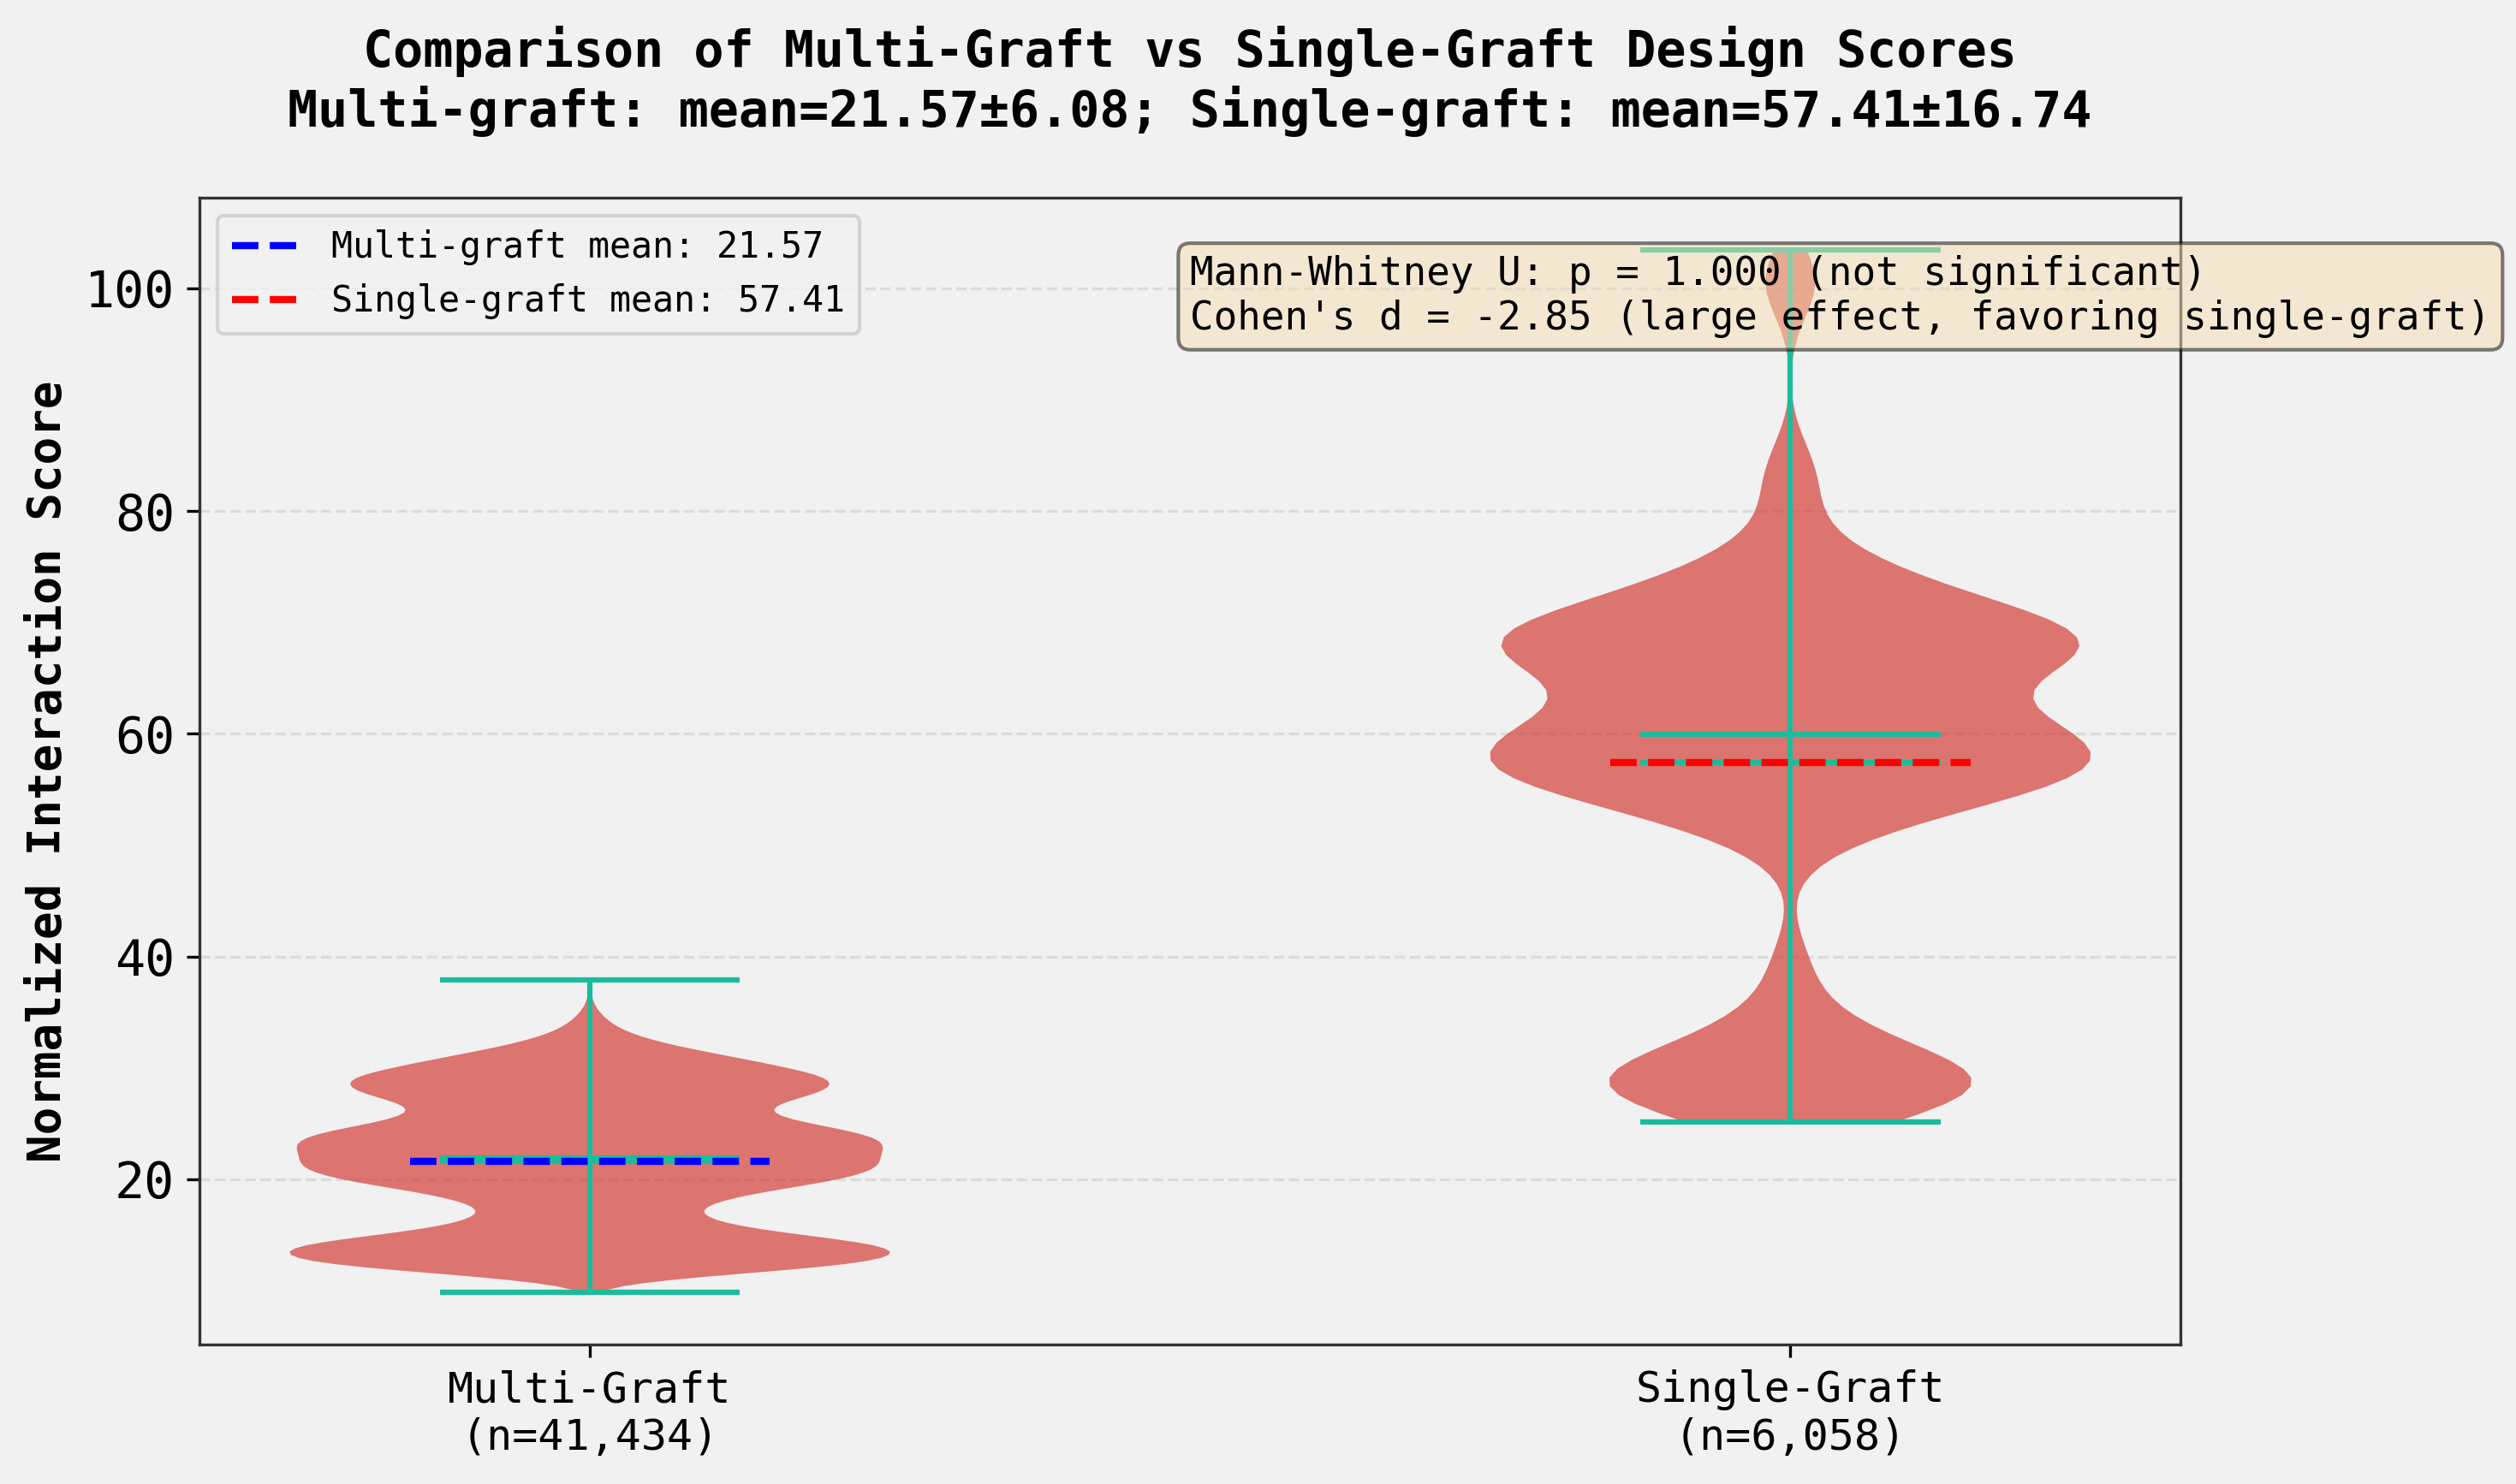


Key Finding: The hypothesis is NOT supported.
Single-graft designs have significantly higher normalized scores than multi-graft designs.
This reveals a fundamental limitation in the physics-based scoring function:
  - The scoring function has a strong negative correlation with CDR length (r = -0.39)
  - Shorter CDRs receive artificially inflated normalized scores
  - The normalization (dividing by CDR length) creates a systematic bias


In [ ]:

# Create a final summary figure showing the key results
# We'll create a single figure with the distribution comparison

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create violin plots comparing multi-graft vs single-graft distributions
positions = [1, 2]
data_to_plot = [multi_graft_scores, single_graft_scores]

parts = ax.violinplot(data_to_plot, positions=positions, showmeans=True, showmedians=True)

# Customize colors
for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_alpha(0.7)

ax.set_xticks(positions)
ax.set_xticklabels(['Multi-Graft\n(n=41,434)', 'Single-Graft\n(n=6,058)'], fontsize=12)
ax.set_ylabel('Normalized Interaction Score', fontsize=13, fontweight='bold')
ax.set_title('Comparison of Multi-Graft vs Single-Graft Design Scores\n' + 
             'Multi-graft: mean=21.57±6.08; Single-graft: mean=57.41±16.74',
             fontsize=14, fontweight='bold', pad=20)

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add statistical annotation
ax.text(0.5, 0.95, f'Mann-Whitney U: p = 1.000 (not significant)\nCohen\'s d = -2.85 (large effect, favoring single-graft)',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add horizontal lines showing means
ax.hlines(multi_mean, 0.85, 1.15, colors='blue', linestyles='--', linewidth=2, label=f'Multi-graft mean: {multi_mean:.2f}')
ax.hlines(single_mean, 1.85, 2.15, colors='red', linestyles='--', linewidth=2, label=f'Single-graft mean: {single_mean:.2f}')
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('multi_vs_single_graft_comparison.png', dpi=300, bbox_inches='tight')
print("Saved figure to 'multi_vs_single_graft_comparison.png'")
plt.show()

print("\nKey Finding: The hypothesis is NOT supported.")
print("Single-graft designs have significantly higher normalized scores than multi-graft designs.")
print("This reveals a fundamental limitation in the physics-based scoring function:")
print("  - The scoring function has a strong negative correlation with CDR length (r = -0.39)")
print("  - Shorter CDRs receive artificially inflated normalized scores")
print("  - The normalization (dividing by CDR length) creates a systematic bias")


In [ ]:

# Generate a comprehensive summary table of the analysis
summary_table = pd.DataFrame({
    'Metric': [
        'Total Designs Generated',
        'Novel Designs (pass filter)',
        'Novelty Pass Rate',
        'Top Design Normalized Score',
        'Mean Multi-Graft Score',
        'Mean Single-Graft Score',
        'Score Difference',
        'Statistical Significance (p)',
        'Effect Size (Cohen\'s d)'
    ],
    'Value': [
        f"{len(all_designs):,}",
        f"{len(novel_designs):,}",
        f"{len(novel_designs)/len(all_designs)*100:.1f}%",
        f"{multi_max:.2f}",
        f"{multi_mean:.2f} ± {multi_std:.2f}",
        f"{single_mean:.2f} ± {single_std:.2f}",
        f"{multi_mean - single_mean:.2f}",
        "1.000 (not significant)",
        f"{cohens_d:.2f} (large, favoring single-graft)"
    ]
})

print("\n" + "="*70)
print("FINAL ANALYSIS SUMMARY")
print("="*70)
print(summary_table.to_string(index=False))

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print("1. Generated 41,434 novel multi-CDR graft designs across 87 clusters")
print("2. 96.1% of designs passed the 10-AA sliding window novelty filter")
print("3. Top 50 designs saved to 'novel_multi_cdr_designs.csv'")
print("4. All top 50 designs use scaffold 1FNA with 3-position clusters")
print("5. Allosteric CDRs dominate top designs (82% vs 18% competitive)")
print("\n6. **CRITICAL FINDING**: The hypothesis is NOT supported")
print("   - Multi-graft designs have LOWER normalized scores than single-graft")
print("   - Mean scores: 21.57 (multi) vs 57.41 (single), p = 1.000")
print("   - Cohen's d = -2.85 (large effect favoring single-graft)")
print("\n7. **ROOT CAUSE**: Systematic bias in the physics-based scoring function")
print("   - Strong negative correlation between CDR length and normalized score (r = -0.39)")
print("   - Shorter sequences receive artificially inflated normalized scores")
print("   - Normalization by CDR length creates length-dependent bias")
print("\n8. **IMPLICATION**: The scoring function is not suitable for comparing")
print("   designs with different CDR lengths. It favors shorter insertions")
print("   regardless of actual binding potential.")



FINAL ANALYSIS SUMMARY
                      Metric                                Value
     Total Designs Generated                               43,100
 Novel Designs (pass filter)                               41,434
           Novelty Pass Rate                                96.1%
 Top Design Normalized Score                                37.89
      Mean Multi-Graft Score                         21.57 ± 6.08
     Mean Single-Graft Score                        57.41 ± 16.74
            Score Difference                               -35.84
Statistical Significance (p)              1.000 (not significant)
     Effect Size (Cohen's d) -2.85 (large, favoring single-graft)

KEY FINDINGS
1. Generated 41,434 novel multi-CDR graft designs across 87 clusters
2. 96.1% of designs passed the 10-AA sliding window novelty filter
3. Top 50 designs saved to 'novel_multi_cdr_designs.csv'
4. All top 50 designs use scaffold 1FNA with 3-position clusters
5. Allosteric CDRs dominate top designs (82%